In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading the dataset

In [2]:
d = np.load("/Users/nipun/Downloads/data-2013-2017-missing.npy").item()

#### Finding homes occuring across both years

In [3]:
np.intersect1d(list(d[2016].keys()), list(d[2015].keys())).size

214

In [4]:
np.intersect1d(list(d[2017].keys()), list(d[2016].keys())).size

153

I would be choosing 2015 and 2016 as the successive years

In [5]:
use_homes = np.intersect1d(list(d[2016].keys()), list(d[2015].keys()))

In [6]:
use_homes

array([  26,   59,   77,   86,   93,   94,  101,  114,  187,  434,  484,
        499,  503,  545,  624,  744,  781,  871,  946,  974, 1086, 1103,
       1169, 1192, 1202, 1283, 1403, 1415, 1463, 1500, 1507, 1589, 1617,
       1632, 1642, 1697, 1700, 1718, 1790, 1800, 1953, 2018, 2094, 2129,
       2156, 2171, 2199, 2233, 2365, 2378, 2472, 2532, 2557, 2575, 2638,
       2755, 2787, 2814, 2818, 2829, 2859, 2945, 2953, 2965, 3009, 3039,
       3044, 3134, 3268, 3310, 3367, 3392, 3456, 3482, 3500, 3527, 3538,
       3577, 3649, 3778, 3829, 3831, 3849, 3916, 3918, 3935, 3967, 4031,
       4154, 4213, 4220, 4297, 4298, 4336, 4342, 4352, 4357, 4373, 4375,
       4473, 4514, 4641, 4767, 4874, 4946, 4957, 4998, 5026, 5060, 5129,
       5218, 5275, 5317, 5357, 5403, 5545, 5568, 5677, 5718, 5785, 5809,
       5814, 5874, 5889, 5921, 5949, 5959, 5972, 6061, 6063, 6121, 6139,
       6165, 6348, 6412, 6423, 6460, 6498, 6691, 6692, 6730, 6990, 7016,
       7030, 7361, 7390, 7429, 7504, 7536, 7560, 76

In [7]:
APPLIANCE_ORDER = ['use', 'air1', 'clotheswasher1', 'drye1', 'furnace1', 'kitchenapp1',
       'microwave1', 'refrigerator1']

### Creating the tensor data

In [8]:
t = np.empty((len(use_homes), len(APPLIANCE_ORDER), 2*12))

In [9]:
t[:] = np.NaN

In [10]:
for i, home in enumerate(use_homes):
    for j, appliance in enumerate(APPLIANCE_ORDER):
        try:
            t[i, j, :12] = d[2016][home][appliance].values
            t[i, j, 12:] = d[2017][home][appliance].values
        except:
            pass

In [11]:
t.shape

(214, 8, 24)

### STF routine

In [12]:
def factorise(tensor, r, random_seed=0, num_iter=400, eps=1e-8, lr=1):
    np.random.seed(random_seed)
    args_num = [1, 2, 3]

    def cost(tensor, home, appliance,  month):
        pred = np.einsum('Hr, Ar, Tr ->HAT', home, appliance, month)
        mask = ~np.isnan(tensor)
        error = (pred - tensor)[mask].flatten()
        return np.sqrt((error ** 2).mean())

    mg = grad(cost, argnum=args_num)
    sizes = [(x, r) for x in tensor.shape]
    home = np.random.rand(*sizes[0])
    appliance = np.random.rand(*sizes[1])
    month = np.random.rand(*sizes[2])

    sum_home = np.zeros_like(home)
    sum_appliance = np.zeros_like(appliance)
    sum_month = np.zeros_like(month)

    # GD procedure
    for i in range(num_iter):
        del_home, del_appliance, del_month = mg(tensor, home, appliance, month)

        sum_home += eps + np.square(del_home)
        lr_home = np.divide(lr, np.sqrt(sum_home))
        home -= lr_home * del_home

        sum_appliance += eps + np.square(del_appliance)
        lr_appliance = np.divide(lr, np.sqrt(sum_appliance))
        appliance -= lr_appliance * del_appliance

        sum_month += eps + np.square(del_month)
        lr_month = np.divide(lr, np.sqrt(sum_month))
        month -= lr_month * del_month

        
        # Projection to non-negative space
        home[home < 0] = 1e-8
        appliance[appliance < 0] = 1e-8
        month[month < 0] = 1e-8

        if i % 500 == 0:
            #print(cost(tensor, home, appliance, month), i)
            sys.stdout.flush()

    return home, appliance, month

#### Creating the different subsets if data

In [13]:
# Test is last 44 homes
test_set = t[170:].copy()
# In test set, we don't know the appliance data
test_set[:, 1:, :] = np.NaN
# Train + Pool is the remaining set
train_pool_set = t[:170].copy()
# Initial train set is 10 homes
train_set = t[:10].copy()
# Initial pool set is 10-170 homes
pool_set = t[10:170].copy()
pool_homes = use_homes[10:170]
# Train + Test set (useful for factorisation)
train_test_set = np.vstack([train_set, test_set])

### Creating the set of (home, appliance) pairs for each month that can contain data and thus can be used for acquiring labels

In [14]:
p_m_h = {}
for month in range(12, 24):
    p_m_h[month] = []
    for home in pool_homes:
        for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
            pool_home_index  = np.searchsorted(use_homes, home)
            if np.isfinite(t[pool_home_index, i+1, month]):
                p_m_h[month].append((home, appliance))

In [15]:
p_m_h[12]

[(499, 'air1'),
 (499, 'furnace1'),
 (499, 'kitchenapp1'),
 (499, 'refrigerator1'),
 (503, 'air1'),
 (503, 'furnace1'),
 (503, 'kitchenapp1'),
 (503, 'microwave1'),
 (503, 'refrigerator1'),
 (744, 'air1'),
 (781, 'air1'),
 (781, 'clotheswasher1'),
 (781, 'drye1'),
 (781, 'furnace1'),
 (781, 'kitchenapp1'),
 (781, 'microwave1'),
 (781, 'refrigerator1'),
 (871, 'air1'),
 (871, 'clotheswasher1'),
 (871, 'drye1'),
 (871, 'furnace1'),
 (871, 'kitchenapp1'),
 (871, 'microwave1'),
 (871, 'refrigerator1'),
 (974, 'air1'),
 (974, 'drye1'),
 (1086, 'air1'),
 (1086, 'furnace1'),
 (1086, 'microwave1'),
 (1086, 'refrigerator1'),
 (1103, 'air1'),
 (1103, 'clotheswasher1'),
 (1169, 'air1'),
 (1169, 'clotheswasher1'),
 (1169, 'drye1'),
 (1169, 'furnace1'),
 (1169, 'kitchenapp1'),
 (1169, 'microwave1'),
 (1169, 'refrigerator1'),
 (1192, 'air1'),
 (1192, 'clotheswasher1'),
 (1192, 'drye1'),
 (1202, 'air1'),
 (1202, 'furnace1'),
 (1415, 'air1'),
 (1415, 'clotheswasher1'),
 (1415, 'drye1'),
 (1415, 'furna

In [16]:
l = list(p_m_h.values())
pd.Series([z[1] for x in l  for z in x  ]).value_counts()

air1              1164
furnace1           797
refrigerator1      689
drye1              636
clotheswasher1     617
microwave1         593
kitchenapp1        438
dtype: int64

#### Randomly adding 5 homes every month from Pool

In [17]:
pred_df_random = {}
from copy import deepcopy
for seed in range(10):
    print("*-*-*"*20)
    print(seed)
    pool_use = np.empty((0, len(APPLIANCE_ORDER), 24))
    pool_set_iter = deepcopy(p_m_h)
    pred_df_random[seed] = {}
    pool_remove_ix = {}
    pool_remove = {}
    gt_df = {}

    for cur_iteration, month in enumerate(range(12, 24)):
        np.random.seed(seed)
        # Randomly choose `n` to remove from pool and put in training set
        pool_remove_ix[cur_iteration] = np.random.choice(range(len(pool_set_iter[month])), size=5)
        pool_remove[month] = [pool_set_iter[month][x] for x in pool_remove_ix[cur_iteration]]

        # Remove these from future months pool too
        for month_f in range(month+1, 24):
            for x in pool_remove[month]:
                if x in pool_set_iter[month_f]:
                    pool_set_iter[month_f].remove(x)


        # Getting data from `t` to create the pool_use_set
        pool_remove_homes = [x[0] for x in pool_remove[month]]
        pool_remove_homes_ix = np.searchsorted(use_homes, pool_remove_homes)

        cur_pool = t[pool_remove_homes_ix, :, :].copy()
        # All past data is unknown
        cur_pool[:, 1:, :month] = np.NaN

        # All future data for all appliances except the chosen one is known
        cur_pool[:, 1:, month:] = np.NaN
        for q, h in enumerate(pool_remove_homes_ix):
            appliance_num = APPLIANCE_ORDER.index(pool_remove[month][q][1])
            cur_pool[q, appliance_num, month-1:] = t[h, appliance_num, month-1:]

        pool_use = np.concatenate([pool_use, cur_pool])

        pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

        h, a, m =factorise(pool_train_test[:, :, :month], 3)
        print(cur_iteration, month, len(pool_train_test), pool_remove[month])

        pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
        pred_df_random[seed][month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
        gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

*-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-*
0
0 12 59 [(3849, 'clotheswasher1'), (1415, 'furnace1'), (2859, 'microwave1'), (4336, 'air1'), (7504, 'drye1')]
1 13 64 [(3849, 'microwave1'), (1415, 'kitchenapp1'), (2953, 'air1'), (4357, 'drye1'), (7560, 'microwave1')]
2 14 69 [(3967, 'clotheswasher1'), (1415, 'microwave1'), (2953, 'drye1'), (4375, 'microwave1'), (7627, 'furnace1')]
3 15 74 [(3967, 'refrigerator1'), (1415, 'refrigerator1'), (2965, 'air1'), (4514, 'drye1'), (7641, 'clotheswasher1')]
4 16 79 [(4213, 'furnace1'), (1500, 'air1'), (2965, 'drye1'), (4946, 'air1'), (7641, 'refrigerator1')]
5 17 84 [(4297, 'air1'), (1500, 'furnace1'), (2965, 'kitchenapp1'), (4946, 'microwave1'), (7769, 'drye1')]
6 18 89 [(4298, 'furnace1'), (1500, 'kitchenapp1'), (2965, 'refrigerator1'), (4998, 'furnace1'), (7788, 'drye1')]
7 19 94 [(4336, 'drye1'), (1500, 'microwave1'), (3009, 'drye1'), (5026, 'air1'), (7850, 'drye1')]
8 20 99 [(4375, 'cloth

8 20 99 [(8046, 'kitchenapp1'), (5317, 'furnace1'), (4946, 'refrigerator1'), (3009, 'drye1'), (2156, 'furnace1')]
9 21 104 [(8059, 'furnace1'), (5545, 'air1'), (4998, 'kitchenapp1'), (3134, 'drye1'), (2156, 'microwave1')]
10 22 109 [(8079, 'kitchenapp1'), (5545, 'microwave1'), (5026, 'clotheswasher1'), (3310, 'drye1'), (2156, 'refrigerator1')]
11 23 114 [(5809, 'clotheswasher1'), (5218, 'microwave1'), (3367, 'clotheswasher1'), (2171, 'air1'), (503, 'refrigerator1')]
*-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-*
6
0 12 59 [(8046, 'air1'), (4375, 'refrigerator1'), (5218, 'furnace1'), (2814, 'air1'), (7850, 'kitchenapp1')]
1 13 64 [(8046, 'refrigerator1'), (4514, 'clotheswasher1'), (5218, 'refrigerator1'), (2814, 'clotheswasher1'), (7875, 'clotheswasher1')]
2 14 69 [(8059, 'kitchenapp1'), (4514, 'furnace1'), (5275, 'furnace1'), (2814, 'drye1'), (7900, 'air1')]
3 15 74 [(8079, 'kitchenapp1'), (4514, 'refrigerator1'), (5275, 'refrigerat

### Active learning

In [18]:
pool_use = np.empty((0, len(APPLIANCE_ORDER), 24))
gt_df = {}
pred_df_active = {}
pool_remove_active = {}
pool_set_active = {}
all_seen = []

for cur_iteration, month in enumerate(range(12, 24)):
    
    # Get all the homes from the currently available pool

    pred_pool = {}
    psc = pool_set.copy()
    psc[:, 1:, :] = np.NaN
    month_contri = (pd.DataFrame(train_set[:, :, month]).mean()/pd.DataFrame(train_set[:, :, month]).mean()[0]).drop(0).to_dict()
    # Starting with current data and finding the variance amongst different #Latent factors
    for r in range(2, 8):
        print(month, r)
        pool_train = np.concatenate([psc, train_set[:, :, :] ])
        h, a, m =factorise(pool_train[:, :, :month], r)
        pred_pool[r] = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)[:len(pool_set)]
        
    # Finding the top-most `n` highly variance homes
    # measure = std/contri
    temp = []
    for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
        y = pd.DataFrame({r:pd.Series(pred_pool[r][:, appliance_num+1, -1])for r in range(2, 8)}).std(axis=1)/month_contri[appliance_num+1]
        y.index = [(x, appliance) for x in pool_homes]
        #y = (y - y.min())/(y.max()-y.min())
        temp.append(y)
        
    pool_remove_active[month] = pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(5).index.tolist() 
    
    all_seen.extend(pool_remove_active[month])
    all_seen = list(set(all_seen))
    
    # Getting data from `t` to create the pool_use_set
    pool_remove_homes_active = [x[0] for x in pool_remove_active[month]]
    pool_remove_homes_active_ix = np.searchsorted(use_homes, pool_remove_homes_active)
    
    cur_pool = t[pool_remove_homes_active_ix, :, :].copy()
    # All past data is unknown
    cur_pool[:, 1:, :month] = np.NaN
    
    # All future data for all appliances except the chosen one is known
    cur_pool[:, 1:, month:] = np.NaN
    for q, h in enumerate(pool_remove_homes_active_ix):
        appliance_num = APPLIANCE_ORDER.index(pool_remove_active[month][q][1])
        cur_pool[q, appliance_num, month-1:] = t[h, appliance_num, month-1:]
    
    pool_use = np.concatenate([pool_use, cur_pool])
    
    pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

    h, a, m =factorise(pool_train_test[:, :, :month], 3)
    print(cur_iteration, month, len(pool_train_test), pool_remove_active[month])
    
    pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
    pred_df_active[month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
    gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

12 2
12 3
12 4
12 5
12 6
12 7
0 12 59 [(2365, 'air1'), (5357, 'kitchenapp1'), (5357, 'microwave1'), (3916, 'air1'), (6691, 'air1')]
13 2
13 3
13 4
13 5
13 6
13 7
1 13 64 [(2365, 'kitchenapp1'), (7016, 'kitchenapp1'), (4154, 'kitchenapp1'), (3500, 'kitchenapp1'), (4874, 'kitchenapp1')]
14 2
14 3
14 4
14 5
14 6
14 7
2 14 69 [(6121, 'kitchenapp1'), (1790, 'kitchenapp1'), (3916, 'kitchenapp1'), (1700, 'kitchenapp1'), (6691, 'kitchenapp1')]
15 2
15 3
15 4
15 5
15 6
15 7
3 15 74 [(4336, 'kitchenapp1'), (2365, 'microwave1'), (3044, 'kitchenapp1'), (7641, 'kitchenapp1'), (7627, 'kitchenapp1')]
16 2
16 3
16 4
16 5
16 6
16 7
4 16 79 [(7719, 'furnace1'), (5357, 'clotheswasher1'), (1700, 'microwave1'), (6691, 'microwave1'), (7016, 'furnace1')]
17 2
17 3
17 4
17 5
17 6
17 7
5 17 84 [(2365, 'clotheswasher1'), (1507, 'kitchenapp1'), (7016, 'clotheswasher1'), (4375, 'kitchenapp1'), (3044, 'clotheswasher1')]
18 2
18 3
18 4
18 5
18 6
18 7
6 18 89 [(4957, 'kitchenapp1'), (5972, 'kitchenapp1'), (484, 'kit

In [19]:
random_error = {}
for seed in range(10):
    random_error[seed] = {}
    for month in range(13, 24):
        random_error[seed][month] = (pd.DataFrame(pred_df_random[seed][month])-pd.DataFrame(gt_df[month])).abs().mean()
active_error = {}
for month in range(13, 24):
    active_error[month] = (pd.DataFrame(pred_df_active[month])-pd.DataFrame(gt_df[month])).abs().mean()

In [20]:
p = pd.Panel(random_error)

/Users/nipun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
p.mean(axis=0)

,13,14,15,16,17,18,19,20,21,22,23
0,179.607494,97.069450,101.942975,108.063423,144.231695,228.291035,226.906615,207.943664,202.213579,170.123003,95.418210
1,7.670111,5.885403,6.251504,5.813371,5.054104,6.542560,7.007335,7.488233,7.383213,5.689960,6.887760
2,32.438362,35.259268,37.435440,39.725322,41.927318,47.112337,42.912394,33.149789,36.668565,39.756718,42.152184
3,131.339288,70.841808,83.283278,101.686080,99.127404,118.036711,128.895289,119.338208,104.297374,76.769745,76.500363
4,9.441015,11.319205,10.199706,11.151778,11.900710,11.381909,10.308467,8.921749,9.236612,9.446441,8.230911
5,10.605133,7.533671,7.135297,8.783432,6.176773,7.731212,7.723148,7.445651,7.405317,6.657098,6.158239
6,40.736071,40.329999,43.859568,42.390708,44.677350,47.606170,47.763140,42.512412,45.585590,41.301941,38.070627


In [22]:
active_unnorm_error = pd.read_csv("active-unnormalised.csv", index_col=0)
active_unnorm_error.index = [int(x) for x in active_unnorm_error.index]
active_unnorm_error.columns = [int(x) for x in active_unnorm_error.columns]

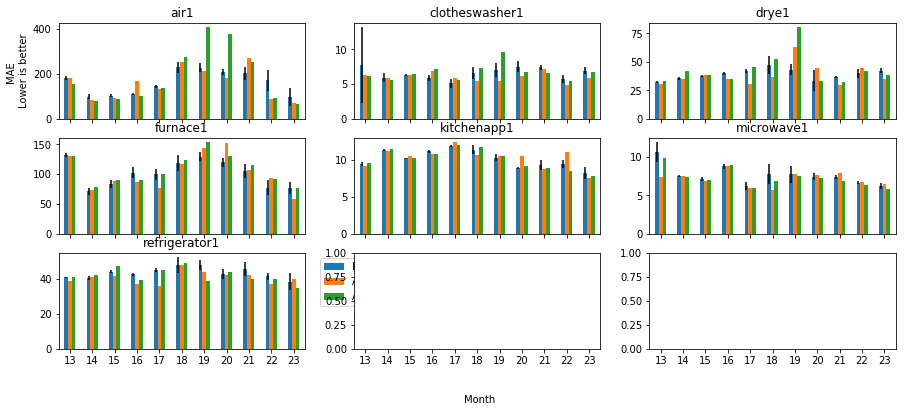

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 6),nrows=3, sharex=True )
for u, appliance in enumerate(APPLIANCE_ORDER[1:]):
    appliance_num = APPLIANCE_ORDER.index(appliance)-1
    re = p.mean(axis=0).iloc[appliance_num]
    ac = pd.DataFrame(active_error).iloc[appliance_num]
    ac_un = active_unnorm_error.iloc[appliance_num]
    pd.DataFrame({"Random":re, "Active-Normalised":ac,"Active-UNNormalised":ac_un }).plot(kind='bar',ax=ax[u//3, u%3], title=appliance,
                                                  yerr =[p.std(axis=0).iloc[appliance_num], np.zeros_like(ac), np.zeros_like(ac_un)], rot=0, legend=False)
fig.text(0.5, 0, "Month")
ax[0, 0].set_ylabel("MAE \nLower is better")
ax[-1, 0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("comparison-active.pdf")
plt.savefig("comparison-active.png")

In [28]:
p.mean(axis=0)

,13,14,15,16,17,18,19,20,21,22,23
0,179.607494,97.069450,101.942975,108.063423,144.231695,228.291035,226.906615,207.943664,202.213579,170.123003,95.418210
1,7.670111,5.885403,6.251504,5.813371,5.054104,6.542560,7.007335,7.488233,7.383213,5.689960,6.887760
2,32.438362,35.259268,37.435440,39.725322,41.927318,47.112337,42.912394,33.149789,36.668565,39.756718,42.152184
3,131.339288,70.841808,83.283278,101.686080,99.127404,118.036711,128.895289,119.338208,104.297374,76.769745,76.500363
4,9.441015,11.319205,10.199706,11.151778,11.900710,11.381909,10.308467,8.921749,9.236612,9.446441,8.230911
5,10.605133,7.533671,7.135297,8.783432,6.176773,7.731212,7.723148,7.445651,7.405317,6.657098,6.158239
6,40.736071,40.329999,43.859568,42.390708,44.677350,47.606170,47.763140,42.512412,45.585590,41.301941,38.070627


In [37]:
ap='microwave1'
(p.mean(axis=0).iloc[APPLIANCE_ORDER.index(ap)-1]-pd.DataFrame(active_error).iloc[APPLIANCE_ORDER.index(ap)-1]).mean()

0.44173877439001036

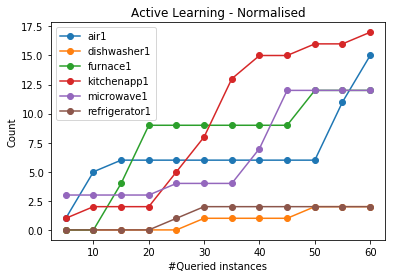

In [51]:
y = list(pool_remove_active.values())
r = {}
for p in range(5, 65, 5):
    r[p] = pd.Series([z[1] for x in y for z in x]).head(p).value_counts()
pd.DataFrame(r).T.fillna(0).plot(marker='o')
plt.xlabel("#Queried instances")
plt.ylabel("Count")
plt.title("Active Learning - Normalised")
plt.savefig("active-normalised-instances.pdf")
plt.savefig("active-normalised-instances.png")

In [26]:
pd.concat(temp).sort_values(ascending=False)

(7719, kitchenapp1)      2054.210318
(1700, kitchenapp1)      1785.213773
(7719, microwave1)       1712.328190
(3918, air1)             1616.412946
(2018, air1)             1595.921469
(1507, air1)             1594.038107
(3039, kitchenapp1)      1582.261662
(5357, kitchenapp1)      1564.150936
(7016, air1)             1551.430679
(7719, dishwasher1)      1532.082893
(3044, kitchenapp1)      1457.880272
(3916, air1)             1434.693513
(1700, microwave1)       1374.848160
(7719, air1)             1363.113888
(1790, air1)             1352.493119
(7719, furnace1)         1303.920144
(2365, air1)             1225.334729
(3039, air1)             1224.037352
(5357, microwave1)       1219.005075
(7793, kitchenapp1)      1187.112895
(7016, furnace1)         1158.176498
(7719, refrigerator1)    1146.798989
(4767, air1)             1140.792186
(4874, air1)             1135.904526
(2787, air1)             1114.481885
(3039, microwave1)       1102.798584
(1790, kitchenapp1)      1100.852583
(

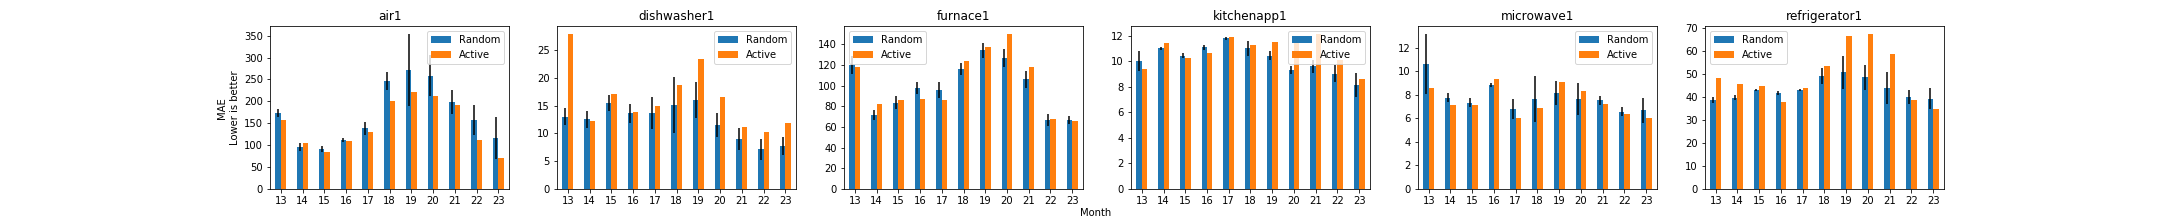

In [27]:
from IPython.display import Image
Image('comparison-active.png')

In [28]:
chosen_homes = {12:[(5357, 'refrigerator1'), (5357, 'dishwasher1'), (4336, 'kitchenapp1'), (4336, 'air1'), (5357, 'microwave1')],
               13:[(3916, 'air1'), (7016, 'furnace1'), (5357, 'kitchenapp1'), (7719, 'refrigerator1'), (4154, 'air1')],
               14:[(2365, 'refrigerator1'), (4375, 'microwave1'), (2365, 'furnace1'), (7719, 'air1'), (4375, 'kitchenapp1')],
               15:[(1700, 'dishwasher1'), (7719, 'furnace1'), (1700, 'microwave1'), (3918, 'furnace1'), (3918, 'kitchenapp1')],
               16: [(1700, 'kitchenapp1'), (5357, 'air1'), (7719, 'dishwasher1'), (2018, 'air1'), (5357, 'furnace1')],
               17: [(7719, 'microwave1'), (2365, 'air1'), (484, 'dishwasher1'), (3044, 'kitchenapp1'), (1790, 'kitchenapp1')],
               18:[(2018, 'dishwasher1'), (7016, 'refrigerator1'), (4957, 'refrigerator1'), (4375, 'refrigerator1'), (3039, 'dishwasher1')],
               19:[(5972, 'refrigerator1'), (5972, 'air1'), (484, 'refrigerator1'), (6691, 'microwave1'), (484, 'air1')],
               20:[(3039, 'furnace1'), (1507, 'kitchenapp1'), (7719, 'kitchenapp1'), (7793, 'furnace1'), (6691, 'kitchenapp1')],
               21:[(4154, 'kitchenapp1'), (3916, 'kitchenapp1'), (3918, 'air1'), (3039, 'kitchenapp1'), (1790, 'air1')],
               22:[(7016, 'air1'), (1507, 'air1'), (3039, 'refrigerator1'), (4767, 'air1'), (1700, 'furnace1')],
               23:[(2018, 'refrigerator1'), (7793, 'refrigerator1'), (5972, 'furnace1'), (3044, 'refrigerator1'), (3039, 'air1')]}

In [29]:
homes = chosen_homes[x][

SyntaxError: unexpected EOF while parsing (<ipython-input-29-a730df5eafcd>, line 1)

In [ ]:
pd.Series([x[0] for x in chosen_homes[12]]).value_counts()

In [ ]:
all_homes = np.array([[x[0] for x in chosen_homes[m]] for m in range(13, 24)]).flatten()

In [ ]:
pd.Series(all_homes).value_counts().plot(kind='bar')

In [ ]:
np.searchsorted(use_homes, 7719)

In [ ]:
pd.DataFrame(t[152, :, :]).iloc[2].plot()

In [ ]:
p_m_h[13]

In [ ]:
{x:len(p_m_h[x]) for x in p_m_h.keys()}


In [ ]:
np.isfinite(t[:, 2:, -1].flatten()).sum()

In [ ]:
p_m_h = {}
for month in range(23, 24):
    p_m_h[month] = []
    for home in pool_homes:
        print(home)
        for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
            pool_home_index  = np.searchsorted(use_homes, home)
            if np.isfinite(t[pool_home_index, i+1, month]):
                p_m_h[month].append((home, appliance))

In [ ]:
len(pool_homes)

In [ ]:
pool_home_index

In [ ]:
np.searchsorted(use_homes, 8084)

In [ ]:
np.isfinite(t[pool_home_index, i+1, month])

In [ ]:
t[169, 1].shape

In [ ]:
np.isfinite(t[169].flatten()).sum()

In [ ]:
p_m_h